In [1]:
import numpy as np
import scipy.io
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import ElasticNet



#Problem 1 - Cross Validation


#Problem setup

#read in data
data = scipy.io.loadmat('HW3_1.mat')

X = data['X'] #351 count of both X and y
y = data['y']
lbda = data['lambdas'] #lbda in range [0, 100] (500 count)
lbda = lbda.flatten() #2d to 1d the lambda hyperparameter array

mix_param = 0.95 #alpha hyperparameter

#perform cross-validation (5 fold so 20% of data is used for testing/test error)

# create outer cv
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

# perform cv operation in each fold
ideal_model_test = list()
ideal_model_train = list()

test_mse = list()
train_mse = list()

for train_ix, test_ix in cv_outer.split(X):
    
    # split data to train and test
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # create inner cv
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # define the model
    model = ElasticNet(l1_ratio = mix_param) #l1_ratio parameter sets the alpha hyperparameter
    
    # define param grid (search space -> looking for optimal lambda)
    parametersGrid = {
                      "alpha": lbda, #alpha parameter sets the lambda hyperparameter
                      }
    
    
    # define search for hyperparameter tuning
    tuning = GridSearchCV(model, parametersGrid, cv=cv_inner, refit=True)
    # search
    optimal_fit = tuning.fit(X_train, y_train)
    
    # get the best performing model and the optimal lambda
    best_model = optimal_fit.best_estimator_
     
    
    #To get test errors for graphing
    # evaluate best lambda estimator model on X_test dataset
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    ideal_model_test.append(y_pred_test)
    ideal_model_train.append(y_pred_train)
    
    #for 1 (c) 
    # evaluate the model for test errors (mse)
    test_error = mean_squared_error(y_test, y_pred_test)
    train_error = mean_squared_error(y_train, y_pred_train)
    
    
    
    # store the mse
    test_mse.append(test_error) 
    train_mse.append(train_error) 
    val_mse = cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = cv_inner) # score of inner cv
    
    # store rmse (errors)
    test_rmse = np.sqrt(test_mse)
    train_rmse = np.sqrt(train_mse)
    val_rmse= np.sqrt(np.abs(val_mse))



In [2]:
#get the needed data for graphing

#min and max mse
minim = list()
maxim = list()
std = list()
mean = list()
opt_lambdas = list()

for i in range(5):
    minim.append(round(ideal_model_test[i][np.argmin(ideal_model_test[i])], 4))
    maxim.append(round(ideal_model_test[i][np.argmax(ideal_model_test[i])], 4))
    std.append(round(np.std(ideal_model_test[i]),4))
    mean.append(round(np.mean(ideal_model_test[i]),4))     
    opt_lambdas.append(round(lbda[np.argmax(ideal_model_test[i])], 6))
    

print('std for each fold {}'.format(std))
print()
print('mean for each fold: {}'.format(mean))
print()
print('minimum: {}'.format(minim))
print()
print('maximum: {}'. format(maxim))
print()

#optimal lbda(better model)
print('optimal lambdas: {}'.format(opt_lambdas))



std for each fold [0.3843, 0.28, 0.2855, 0.3264, 0.33]

mean for each fold: [0.6017, 0.7082, 0.6453, 0.6494, 0.6511]

minimum: [-0.7691, -0.2947, -0.1185, -0.4245, -0.5953]

maximum: [0.9678, 1.0603, 0.9829, 1.151, 0.9427]

optimal lambdas: [3.9e-05, 5.2e-05, 7.2e-05, 4.1e-05, 1.3e-05]


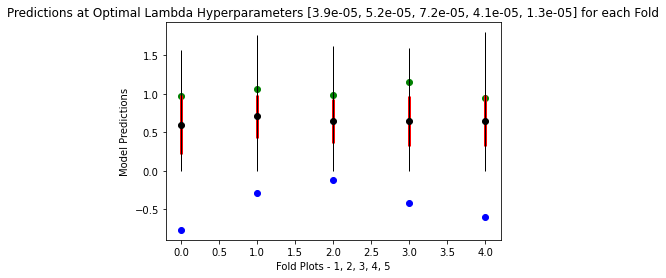

In [3]:
from matplotlib import pyplot as plt

#Probem 1 (b) - model plotting

#plot the mean, std of errors 
mins = list(set(mean) - set(minim))
maxs = list(set(maxim) - set(mean))


plt.errorbar(np.arange(5), mean, std, fmt = 'ok', lw = 3, ecolor = 'red')
plt.errorbar(np.arange(5), mean, [mins, maxs], fmt = '.k', ecolor = 'black', lw = 1)

#plot the min and max of errors
x_points = [0.0, 1.0, 2.0, 3.0, 4.0]
max_points = np.full(5, maxim)
min_points = np.full(5, minim)

plt.scatter(x_points, max_points, color = 'green')
plt.scatter(x_points, min_points, color = 'blue')

plt.title('Predictions at Optimal Lambda Hyperparameters {} for each Fold'.format(opt_lambdas))
plt.xlabel('Fold Plots - 1, 2, 3, 4, 5')
plt.ylabel('Model Predictions')

plt.show()



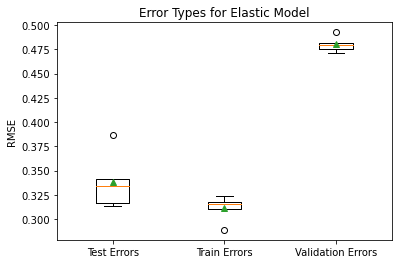

In [21]:
#Problem 1 (c) - error plotting and discussion

errors_dict = {'Test Errors': test_rmse, 'Train Errors': train_rmse, 'Validation Errors': val_rmse}

fig, ax = plt.subplots()

ax.boxplot(errors_dict.values(), showmeans = True)
ax.set_xticklabels(errors_dict.keys())

plt.ylabel('RMSE')
plt.title('Error Types for Elastic Model')

plt.show()


# Errors Discussion


# First, let us start with the training errors. These errors are the ones we get when we trained the elastic model on the training data.
# Hence, these errors tell us how well the model learned from the training data. From our data, our training error (RMSE) is low that signifies that the model is a good fit to the training data.
# This is to be expected as we trained the model directly on the training data, hence, good results are expected. 

# Secondly, let us talk about the validation errors. These errors tell us how well the parameters of the model generalises as it is unseen data. However, in the process of cross validation, we optimize the parameters.
# Hence, in theory, this should make the validation error have a lower RMSE since the model should fit better on the validation data. Another explanation can be that the parameter tuning is harder as there are 'harder' cases to predict.
# My results do not reflect that and I think that is mainly due to errors where I did not split the validation set properly, hence I did not successfully fit the model on the validation set.

# Finally, let us talk about the test errors. These errors are completely unseen data and the training model is not optimized to fit to the test data. 
# Hence, it provides a very good indicator to the model's generalizability. 
# My results reflect good results in general where the RMSE is relatively low. However, there is a bit of a higher IQR score, meaning it is not entirely precise. 

# In general, all 3 errors show good results as a RMSE of between 0.200 to 0.500 shows that the Elastic Net model is able to predict the data accurately.
# With the exception of validation error, the test and train error results were expected where the model performed better on the training data then the test data. 
# Hence, I would say that the models selected by nested k-fold CV proprely optimized the bias-variance trade-off. 



In [5]:
#Problem 2 - Elastic Net Logistic Regression

import warnings
warnings.filterwarnings('ignore')

#IRLS
#solve optimization problem by minimizing cost function iteratively by solving weighted least squares problem 

from scipy import linalg

N = 351 #number of values in X
 
weights = np.linspace(1, 2, N) #34 iteratively reweighted X
Xw = X * np.sqrt(weights)[:, None]
yw = y * np.sqrt(weights)
newX = linalg.lstsq(Xw, yw)[0]
newX = np.reshape(newX, (351, 34))


#run the elastic net model on the reweighted values of X

mix_param = 0.95 #alpha hyperparameter

#perform cross-validation (5 fold so 20% of data is used for testing/test error)

# create outer cv
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

# perform cv operation in each fold
ideal_model_test = list()
ideal_model_train = list()

test_mse = list()
train_mse = list()

for train_ix, test_ix in cv_outer.split(X):
    
    # split data to train and test
    X_train, X_test = newX[train_ix, :], newX[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # create inner cv
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # define the model
    model = ElasticNet(l1_ratio = mix_param) #l1_ratio parameter sets the alpha hyperparameter
    
    # define param grid (search space -> looking for optimal lambda)
    parametersGrid = {
                      "alpha": lbda, #alpha parameter sets the lambda hyperparameter
                      }
    
    
    # define search for hyperparameter tuning
    tuning = GridSearchCV(model, parametersGrid, cv=cv_inner, refit=True)
    # search
    optimal_fit = tuning.fit(X_train, y_train)
    
    # get the best performing model and the optimal lambda
    best_model = optimal_fit.best_estimator_
     
    
    #To get test errors for graphing
    # evaluate best lambda estimator model on X_test dataset
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    ideal_model_test.append(y_pred_test)
    ideal_model_train.append(y_pred_train)


#Soft-thresholding
#Using thresholding helper module to implement soft thresholding 
# https://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html

#Soft-threshold for every lambda value

import pywt 

threshold_data = list()

for i in range(len(lbda)):
    for j in range(5):
        threshold_data.append(pywt.threshold(ideal_model_test[j], lbda[i], mode='soft'))


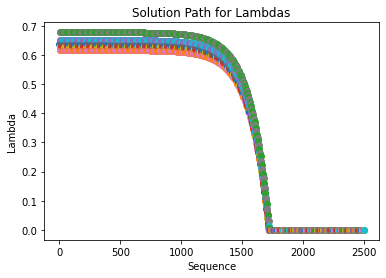

In [22]:
#plot the result

import statistics

x_plot = list(range(0, len(threshold_data)))

for i in range(len(threshold_data)):
    plt.scatter(x_plot[i], statistics.mean(threshold_data[i]))

plt.title('Solution Path for Lambdas')
plt.xlabel('Sequence')
plt.ylabel('Lambda')
plt.show()